In [1]:
import pandas as pd
import numpy as np
import scGeneRAI
import os
import networkx as nx

In [2]:
ex_data = pd.read_csv('../scGeneRAI/example_data/example_data.csv').iloc[:,3:]
ex_data_descriptors = pd.read_csv('../scGeneRAI/example_data/example_data.csv').iloc[:,1:3]

In [3]:
means = ex_data.mean(axis=0)
sds = ex_data.std(axis=0)

ex_data = (ex_data-means)/sds

In [4]:
ex_data

,ID1,ID2,ID3,ID4,JUN,FOS,FOSB,HSPA5,HSP90B1,RPS27,RPL10,EEF1A1
0,-0.822425,-0.568856,-0.489781,-0.674394,1.879223,1.379676,0.351501,-1.150921,-1.275954,0.040564,-1.253996,-0.385435
1,-0.822425,-0.568856,-0.489781,-0.674394,-0.950254,0.144891,-0.458110,0.044986,0.639729,-0.985498,-1.253996,-0.551989
2,-0.822425,-0.568856,-0.489781,-0.674394,1.026293,2.298697,2.171448,-1.150921,-0.067292,-1.227448,-0.971707,-0.551989
3,-0.822425,-0.568856,-0.489781,-0.674394,-0.185621,1.150822,1.298686,-1.150921,-0.067292,-0.307607,-0.377126,-1.216612
4,-0.822425,-0.568856,-0.489781,-0.674394,-1.714887,-0.565995,-1.267721,-1.150921,-1.275954,-1.523571,-2.130866,-1.216612
...,...,...,...,...,...,...,...,...,...,...,...,...
18109,2.523332,-0.568856,5.503325,-0.674394,0.708942,0.439936,0.351501,2.640015,0.639729,0.316112,0.958840,0.671186
18110,-0.822425,-0.568856,-0.489781,-0.674394,-1.714887,-1.692723,-1.267721,-1.150921,1.141369,0.738716,1.207689,0.428176
18111,1.111857,-0.568856,3.816655,-0.674394,0.060536,-0.042096,-0.458110,2.206414,-0.067292,0.612235,1.207689,0.594730
18112,1.677598,0.649013,5.350639,-0.674394,0.708942,-0.042096,0.351501,3.402322,1.530472,-1.523571,-0.377126,-0.551989


In [5]:
ex_data_descriptors

,patient_id,cell_type_epi
0,p018,Ciliated
1,p018,Ciliated
2,p018,Tumor
3,p018,AT1
4,p018,Tumor
...,...,...
18109,p034,Tumor
18110,p034,Tumor
18111,p034,Tumor
18112,p034,Tumor


In [6]:
model = scGeneRAI.scGeneRAI()

In [17]:
model.fit(ex_data, nepochs = 100, model_depth =2, descriptors = ex_data_descriptors, early_stopping=True, device_name = 'cpu')


100%|█████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it]

the network trained for 80 epochs (testloss: 0.13073371350765228)


In [26]:
model.predict_networks(ex_data.iloc[:50,:], descriptors = ex_data_descriptors.iloc[:50,:], PATH = '.')

In [27]:
ex_data_descriptors.shape

(18114, 2)

In [28]:
files = os.listdir('./results')

In [29]:
network_data = pd.concat([pd.read_csv('./results/' + file) for file in files])

In [30]:
network_data['LRP'] = np.abs(network_data['LRP'])
network_data = network_data[network_data['source_gene'] != network_data['target_gene']]

average_network = network_data[['LRP', 'source_gene', 'target_gene']].groupby(['source_gene', 'target_gene']).mean().reset_index()
average_network

,source_gene,target_gene,LRP
0,FOS,EEF1A1,0.018700
1,FOSB,EEF1A1,0.011876
2,FOSB,FOS,0.119806
3,HSP90B1,EEF1A1,0.019836
4,HSP90B1,FOS,0.020628
...,...,...,...
61,RPS27,ID2,0.007499
62,RPS27,ID3,0.011852
63,RPS27,ID4,0.020631
64,RPS27,JUN,0.024504


In [31]:
edges = average_network.sort_values(by='LRP', ascending=False).iloc[:20,:]
edges

,source_gene,target_gene,LRP
65,RPS27,RPL10,0.158611
37,JUN,FOS,0.121053
2,FOSB,FOS,0.119806
45,RPL10,EEF1A1,0.110893
38,JUN,FOSB,0.109121
55,RPS27,EEF1A1,0.060431
9,HSPA5,HSP90B1,0.050556
49,RPL10,HSPA5,0.035375
57,RPS27,FOSB,0.033500
47,RPL10,FOSB,0.031428


In [32]:
network = nx.from_pandas_edgelist(edges, source='source_gene', target='target_gene', edge_attr='LRP')

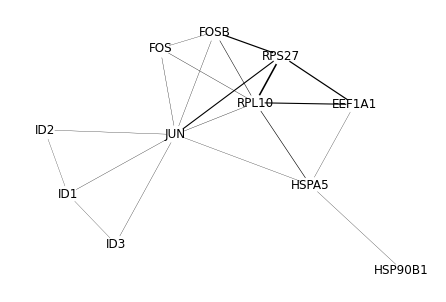

In [33]:
nx.draw(network, with_labels=True, node_color='white', width = edges['LRP']*10)